# San Francisco Bike Share Analaysis


## Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploratory Analysis

To begin to really dive into the data, I would like to visualize the bike trip frequency per hour in the day to see if there are any trends.

In [2]:
%%bigquery df1

SELECT EXTRACT(HOUR from start_date) as ride_start, count(*) as trip_freq FROM `bigquery-public-data.san_francisco.bikeshare_trips`
group by ride_start

#First query to take a broad look at how many trips are taken for every hour

Downloading: 100%|██████████| 24/24 [00:03<00:00,  6.39rows/s]


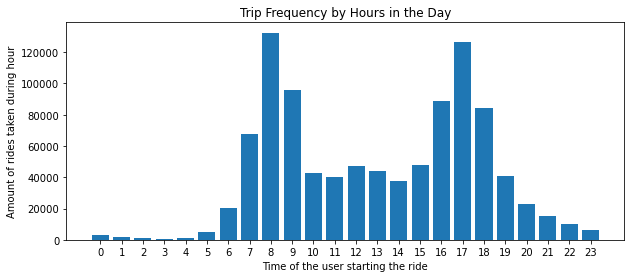

In [3]:
# Create a bar chart showing the trip frequency for every hour in the day
df1.reset_index().set_index('ride_start')

x = df1.ride_start
y = df1.trip_freq

fig, ax = plt.subplots(figsize = (10,4))

ax.bar(x, y, align = 'center', width = 0.8)

ax.set_xticks(df1.ride_start)
ax.set_xlabel('Time of the user starting the ride')
ax.set_ylabel('Amount of rides taken during hour')
ax.set_title('Trip Frequency by Hours in the Day')

plt.show()

The above graph shows peak hours for bike rides are around the 8 a.m. timeframe as well as the 5 p.m. timeframe. This would align with typical commute hours for the average american. Let's define commute hours, as between 7 a.m. and 9 a.m. and 4 p.m. and 6 p.m. Furthermore, to eliminate any trip that seems unreasonable, we will clean the data by putting a limit of trip duration as under 4 hours. We will assume that any trip greater than 4 hours is an anomoly, as this is unreasonable for a bike share trip in the Bay Area.

To further understand exactly how many trips come during these commute hours, let's run a query to find out

In [4]:
%%bigquery df_commute_trips

select count(*) trip_cnt FROM `bigquery-public-data.san_francisco.bikeshare_trips`  
where
(EXTRACT(HOUR from start_date) > 7 and EXTRACT(HOUR from start_date) < 9 or
EXTRACT(HOUR from end_date) > 7  and EXTRACT(HOUR from end_date) < 9 or
EXTRACT(HOUR from start_date) > 16 and EXTRACT(HOUR from start_date) < 18 or
EXTRACT(HOUR from end_date) > 16  and EXTRACT(HOUR from end_date) < 18)

#query to look at the total trips which occur during the commute hours 

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.14s/rows]


In [5]:
%%bigquery df_non_commute_trips

select count(*) trip_cnt FROM `bigquery-public-data.san_francisco.bikeshare_trips`  
where
(EXTRACT(HOUR from start_date) NOT BETWEEN 7 and 9) and 
(EXTRACT(HOUR from start_date) NOT BETWEEN 16 and 18) and
(EXTRACT(HOUR from end_date) NOT BETWEEN 7 and 9) and 
(EXTRACT(HOUR from end_date) NOT BETWEEN 16 and 18) 
and DATE_DIFF(end_date,start_date,HOUR) < 4 

#query to look at the total trips which occur during the non commute hours 

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.16s/rows]


| Amount of Trips <br>during Commute Hours 	| Amount of Trips <br>during Non-Commute Hours 	|
|:----------------------------------------:	|:--------------------------------------------:	|
|                  295,903                 	|                    361,874                   	|

295k trips coming from these commute hour time periods, and 361k coming from non-commute hours. Considering commute hours only take up 25% of the day, this is quite a stark difference in the magnitude of riders during these commute time periods.

During these commute hours, what are the most popular stations by bike trip frequency?

In [6]:
%%bigquery df_morn_station

SELECT start_station_name,end_station_name, count(*) trip_cnt
FROM `bigquery-public-data.san_francisco.bikeshare_trips`  
WHERE
(EXTRACT(HOUR from start_date) > 7 and EXTRACT(HOUR from start_date) < 9 or
EXTRACT(HOUR from end_date) > 7  and EXTRACT(HOUR from end_date) < 9)
and (DATE_DIFF(end_date,start_date,HOUR) < 4) 
group by start_station_name,end_station_name
order by 3 desc,start_station_name,end_station_name
limit 10

#Looking to see what the popular trips are during the morning commute hours 

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.36rows/s]


In [7]:
display(df_morn_station)

,start_station_name,end_station_name,trip_cnt
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,3118
1,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),1959
2,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,1745
3,San Francisco Caltrain (Townsend at 4th),Steuart at Market,1703
4,Steuart at Market,Embarcadero at Sansome,1676
5,San Francisco Caltrain (Townsend at 4th),Market at Sansome,1603
6,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,1594
7,Steuart at Market,2nd at Townsend,1525
8,San Francisco Caltrain (Townsend at 4th),Howard at 2nd,1524
9,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,1473


An interesting finding from the above chart is the amount of rides that start/end from caltrain stations during the morning commute. Out of the top 10, 6 either start or end at a caltrain station. 

Let's see if this same trend is replicated during the evening commute hours.

In [8]:
%%bigquery df_evening_station

SELECT start_station_name,end_station_name, count(*) trip_cnt
FROM `bigquery-public-data.san_francisco.bikeshare_trips`  
WHERE
(EXTRACT(HOUR from start_date) > 16 and EXTRACT(HOUR from start_date) < 19 or
EXTRACT(HOUR from end_date) > 16  and EXTRACT(HOUR from end_date) < 19)
and (DATE_DIFF(end_date,start_date,HOUR) < 4) 
group by start_station_name,end_station_name
order by 3 desc,start_station_name,end_station_name
limit 10

#Looking to see what the popular trips are during the evening commute hours 

Downloading: 100%|██████████| 10/10 [00:01<00:00,  8.99rows/s]


In [9]:
display(df_evening_station)

,start_station_name,end_station_name,trip_cnt
0,Embarcadero at Sansome,Steuart at Market,2981
1,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),2951
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),2839
3,2nd at South Park,Market at Sansome,2679
4,Market at 10th,San Francisco Caltrain 2 (330 Townsend),2646
5,Steuart at Market,San Francisco Caltrain (Townsend at 4th),2547
6,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),2322
7,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),2224
8,Howard at 2nd,San Francisco Caltrain (Townsend at 4th),2078
9,2nd at Townsend,Steuart at Market,1883


Again, we see that 6 out of 10 of the most popular evening commute hour trips come from Caltrain Stations. My hypothesis is that many commuters are using our bikes to go "the last mile" from the caltrain station to their home or office.

To further quantify this, lets calculate the percentage of the commute hour rides that come from Caltrain Stations vs non-caltrain stations.  

In [10]:
%%bigquery df_caltrain_commute

SELECT count(*) caltrain_rides_during_commute_hours
FROM   `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (start_station_name = 'Redwood City Caltrain Station' or
start_station_name = 'Mountain View Caltrain Station' or
start_station_name = 'San Jose Diridon Caltrain Station' or
start_station_name = 'San Antonio Caltrain Station'or
start_station_name = 'San Francisco Caltrain 2 (330 Townsend)' or
start_station_name = 'San Francisco Caltrain (Townsend at 4th)' or
start_station_name = 'Palo Alto Caltrain Station' or
start_station_name = 'Evelyn Park and Ride' or
end_station_name = 'Redwood City Caltrain Station' or
end_station_name = 'Mountain View Caltrain Station' or
end_station_name = 'San Jose Diridon Caltrain Station' or
end_station_name = 'San Antonio Caltrain Station'or
end_station_name = 'San Francisco Caltrain 2 (330 Townsend)' or
end_station_name = 'San Francisco Caltrain (Townsend at 4th)' or
end_station_name = 'Palo Alto Caltrain Station' or
end_station_name = 'Evelyn Park and Ride') and
(EXTRACT(HOUR from start_date) > 7 and EXTRACT(HOUR from start_date) < 9 or
EXTRACT(HOUR from end_date) > 7  and EXTRACT(HOUR from end_date) < 9 or
EXTRACT(HOUR from start_date) > 16 and EXTRACT(HOUR from start_date) < 18 or
EXTRACT(HOUR from end_date) > 16  and EXTRACT(HOUR from end_date) < 18)
and DATE_DIFF(end_date,start_date,HOUR) < 4  

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.33s/rows]


In [11]:
df_caltrain_commute['total_rides_during_commute'] = 295903 #total rides calculated above
df_caltrain_commute['Percent_of_commute_rides_from_caltrain'] = (df_caltrain_commute['caltrain_rides_during_commute_hours'] / df_caltrain_commute['total_rides_during_commute']) * 100
display(df_caltrain_commute)

,caltrain_rides_during_commute_hours,total_rides_during_commute,Percent_of_commute_rides_from_caltrain
0,125124,295903,42.285479


There are 295,903 total rides during commute hours and 125,124 of those rides start or end at a caltrain station. This means that 42.3% of all rides during commute hours, our busiest time for bike rentals, comes from users either going to or from a caltrain station. 

The data set has each of the trips labeled as coming from one of our subscribers or not. Our subscribers are members who pay a monthly fee and are able to use unlimited rides instead of paying per ride. I would like to anaylze what percentage of the caltrain commuters are subscribers. 

In [12]:
%%bigquery df_caltrain_subscriber

SELECT count(*) caltrain_subscriber_commute_rides
FROM   `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (start_station_name = 'Redwood City Caltrain Station' or
start_station_name = 'Mountain View Caltrain Station' or
start_station_name = 'San Jose Diridon Caltrain Station' or
start_station_name = 'San Antonio Caltrain Station'or
start_station_name = 'San Francisco Caltrain 2 (330 Townsend)' or
start_station_name = 'San Francisco Caltrain (Townsend at 4th)' or
start_station_name = 'Palo Alto Caltrain Station' or
start_station_name = 'Evelyn Park and Ride' or
end_station_name = 'Redwood City Caltrain Station' or
end_station_name = 'Mountain View Caltrain Station' or
end_station_name = 'San Jose Diridon Caltrain Station' or
end_station_name = 'San Antonio Caltrain Station'or
end_station_name = 'San Francisco Caltrain 2 (330 Townsend)' or
end_station_name = 'San Francisco Caltrain (Townsend at 4th)' or
end_station_name = 'Palo Alto Caltrain Station' or
end_station_name = 'Evelyn Park and Ride') and
(EXTRACT(HOUR from start_date) > 7 and EXTRACT(HOUR from start_date) < 9 or
EXTRACT(HOUR from end_date) > 7  and EXTRACT(HOUR from end_date) < 9 or
EXTRACT(HOUR from start_date) > 16 and EXTRACT(HOUR from start_date) < 18 or
EXTRACT(HOUR from end_date) > 16  and EXTRACT(HOUR from end_date) < 18) and 
subscriber_type = 'Subscriber'
and DATE_DIFF(end_date,start_date,HOUR) < 4  



Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.33s/rows]


In [13]:
df_caltrain_subscriber['caltrain_rides_during_commute_hours'] = 125124 #total rides calculated above
df_caltrain_subscriber['Percent_of_commute_rides_from_subscriber'] = (df_caltrain_subscriber['caltrain_subscriber_commute_rides'] / df_caltrain_subscriber['caltrain_rides_during_commute_hours']) * 100
display(df_caltrain_subscriber)

,caltrain_subscriber_commute_rides,caltrain_rides_during_commute_hours,Percent_of_commute_rides_from_subscriber
0,120745,125124,96.500272


96.5% of all Caltrain commuter rides come from subscribers. This is a very useful analysis as I move forward and how we tailor our promotional offer. In addition, out of the 983,648 trips, 120,745 are attributted to our subscribers going to or from a caltrain station during the defined commuter hours. This comes out to 12% of our total trips can be attributted to this one use case.

### How do Caltrain stations differ within commute hours vs non-commute hours?

In [14]:
%%bigquery caltrain_hour

SELECT start_station_name, end_station_name, EXTRACT(HOUR from start_date) as ride_start, count(*) as trip_freq
FROM   `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE (start_station_name = 'Redwood City Caltrain Station' or
start_station_name = 'Mountain View Caltrain Station' or
start_station_name = 'San Jose Diridon Caltrain Station' or
start_station_name = 'San Antonio Caltrain Station'or
start_station_name = 'San Francisco Caltrain 2 (330 Townsend)' or
start_station_name = 'San Francisco Caltrain (Townsend at 4th)' or
start_station_name = 'Palo Alto Caltrain Station' or
start_station_name = 'Evelyn Park and Ride' or
end_station_name = 'Redwood City Caltrain Station' or
end_station_name = 'Mountain View Caltrain Station' or
end_station_name = 'San Jose Diridon Caltrain Station' or
end_station_name = 'San Antonio Caltrain Station'or
end_station_name = 'San Francisco Caltrain 2 (330 Townsend)' or
end_station_name = 'San Francisco Caltrain (Townsend at 4th)' or
end_station_name = 'Palo Alto Caltrain Station' or
end_station_name = 'Evelyn Park and Ride')
group by start_station_name,end_station_name, ride_start

#query to collect info on all trips that start or end at a caltrain station

Downloading: 100%|██████████| 4873/4873 [00:01<00:00, 4052.61rows/s]


In [15]:
#Do some pandas transforms to split the dataset for charting

#Creating lists for both the hours which are defined as commute hours as well as bike stations which are related to Caltrain stations
commute_list = [7,8,9,16,17,18]
caltrain_list = ['Redwood City Caltrain Station', 'Mountain View Caltrain Station', 'San Jose Diridon Caltrain Station',
'San Antonio Caltrain Station', 'San Francisco Caltrain 2 (330 Townsend)', 'San Francisco Caltrain (Townsend at 4th)',
'Palo Alto Caltrain Station', 'Evelyn Park and Ride']

#Adding columns to further categorize data frame
caltrain_hour['is_commute'] = np.where(caltrain_hour['ride_start'].isin([7,8,9,16,17,18]), True, False) 
caltrain_hour['is_start'] = np.where(caltrain_hour['start_station_name'].isin(caltrain_list), True, False)
caltrain_hour['is_end'] = np.where(caltrain_hour['end_station_name'].isin(caltrain_list), True, False)


#Splitting the data set further into set which include the caltrain stop at the start or end of their ride
cal_commute_start = caltrain_hour[(caltrain_hour['is_commute'] == True) & (caltrain_hour['is_start'] == True)]
cal_commute_end = caltrain_hour[(caltrain_hour['is_commute'] == True) & (caltrain_hour['is_end'] == True)]
no_commute_start = caltrain_hour[(caltrain_hour['is_commute'] == False) & (caltrain_hour['is_start'] == True)]
no_commute_end = caltrain_hour[(caltrain_hour['is_commute'] == False) & (caltrain_hour['is_end'] == True)]



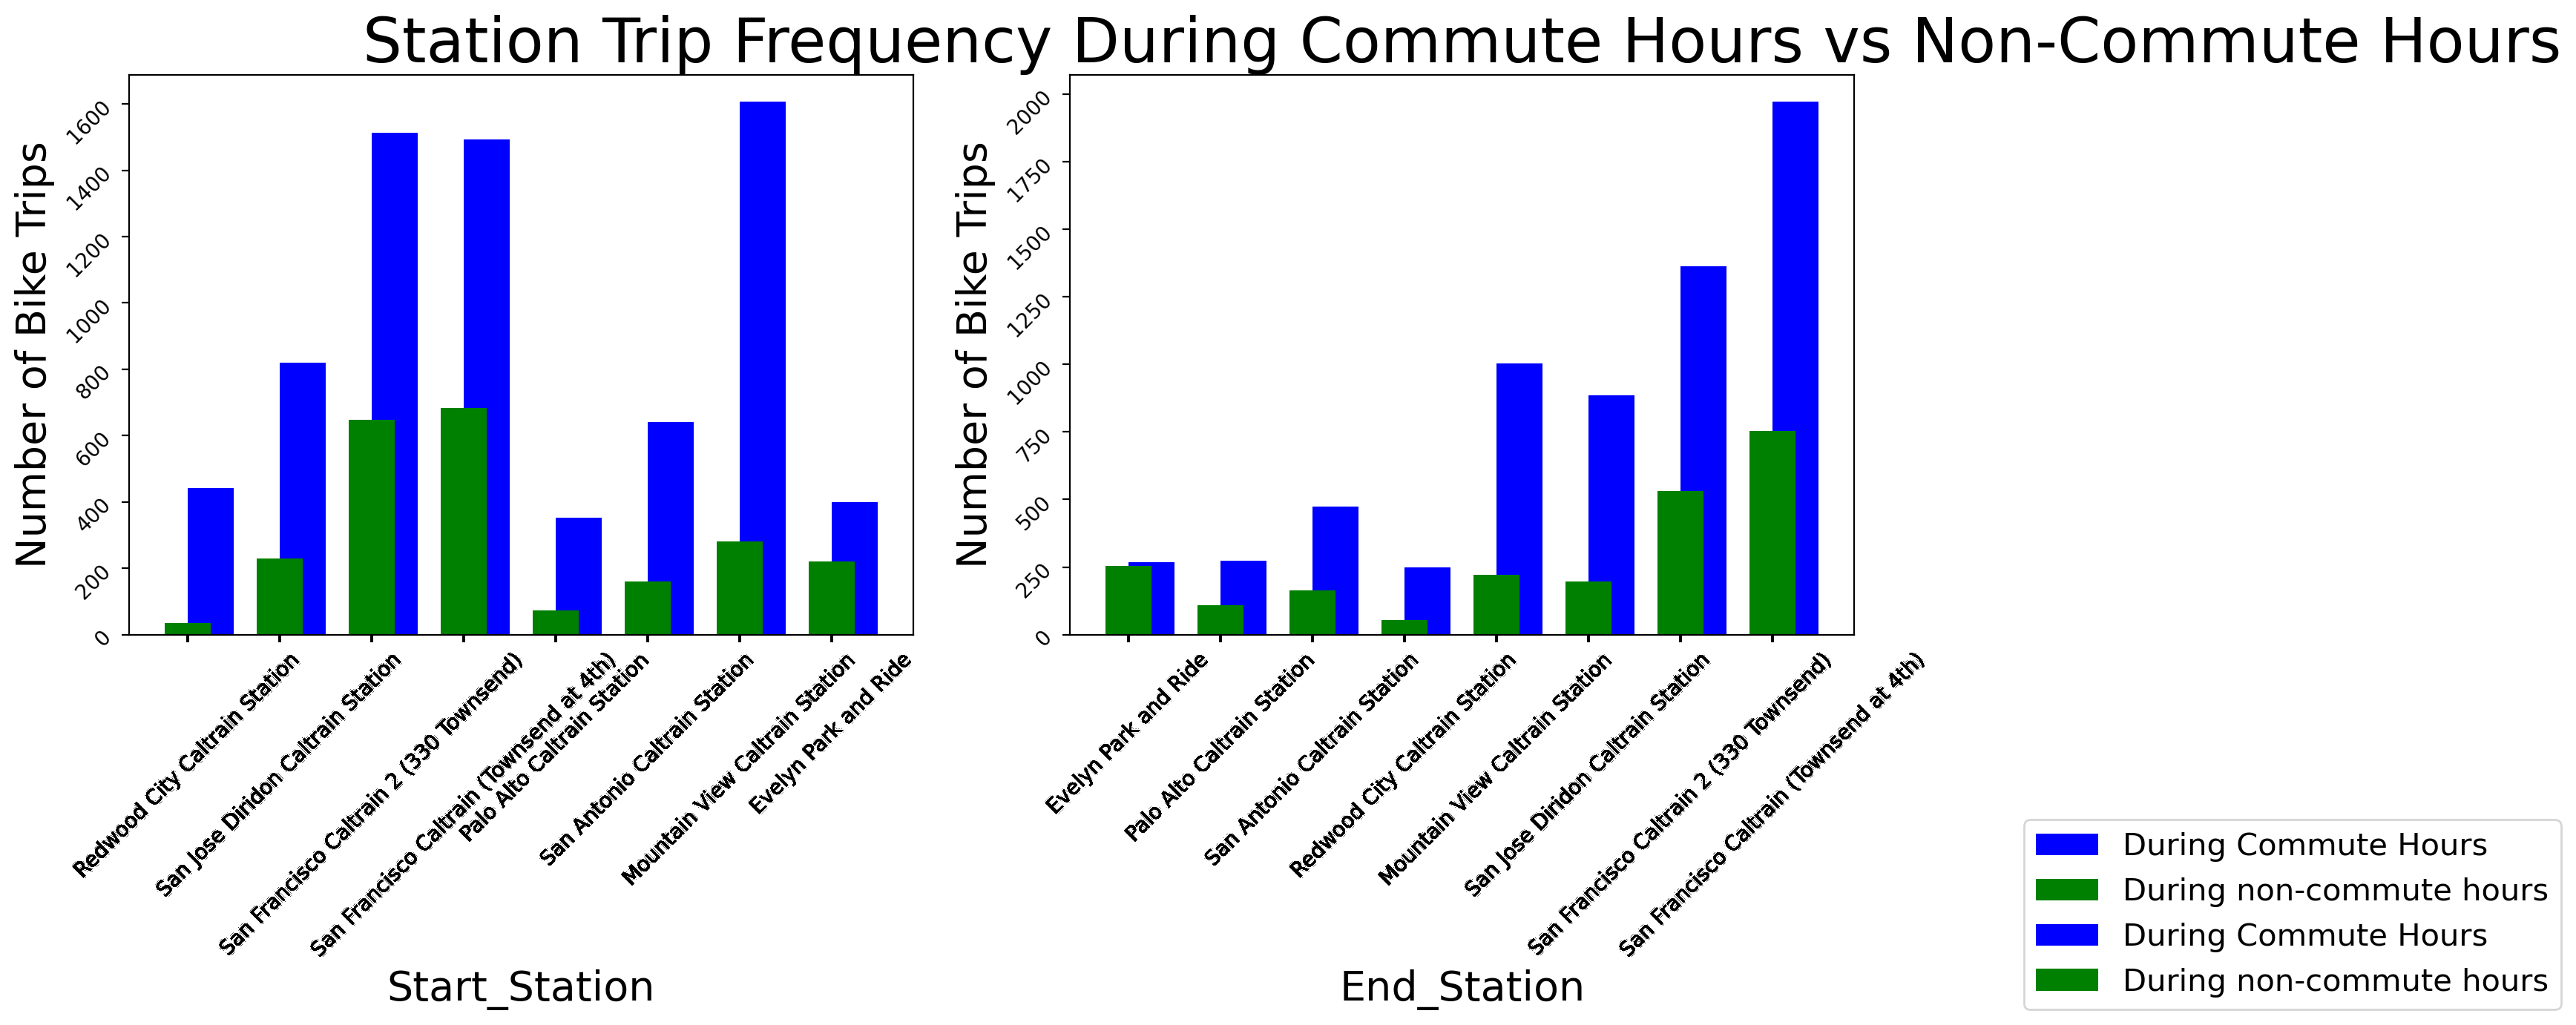

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (15,5), dpi=200)

#create axis for start staion graph
x= no_commute_start.start_station_name
x1 = cal_commute_start.start_station_name
y = cal_commute_start.trip_freq
z = no_commute_start.trip_freq

#create axis for end station graph
x_e= no_commute_end.end_station_name
x1_e = cal_commute_end.end_station_name
y_e = cal_commute_end.trip_freq
z_e = no_commute_end.trip_freq

#Start station Bar graph creation
ax[0].bar(x1, y, width=0.5, color='b', align='edge', label = 'During Commute Hours')
ax[0].bar(x, z, width=0.5, color='g', align='center', label = 'During non-commute hours')

#End Station Bar graph creation 
ax[1].bar(x1_e, y_e, width=0.5, color='b', align='edge', label = 'During Commute Hours')
ax[1].bar(x_e, z_e, width=0.5, color='g', align='center', label = 'During non-commute hours')


#Setting Plot labels for both graphs and title
ax[0].set_xlabel("Start_Station", fontsize= 20)
ax[1].set_xlabel("End_Station", fontsize= 20)
ax[0].set_ylabel('Number of Bike Trips', fontsize= 20)
ax[1].set_ylabel('Number of Bike Trips', fontsize= 20)
plt.title('Station Trip Frequency During Commute Hours vs Non-Commute Hours', fontsize = 30)

#Updating tick marks for readability
ax[0].set_xticks(no_commute_start.start_station_name)
ax[1].set_xticks(no_commute_end.end_station_name)
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)

fig.legend(fontsize = 15, loc='lower right')
plt.show()

# 

# 

The above chart shows almost all of the Caltrain station bike locations see an increased amount of bike trips during commute hours. This makes sense given the amount of people in the Bay Area who use Caltrain to commute either into SF or down to Silicon Valley. Based on this finding, as well as the previous findings in this notebook, we will define a commute trip to specifically be: "Any trip to or from a caltrain location during commute hours (7 a.m. to 9 a.m and 4 p.m. to 6 p.m.)"

## Top 5 Commute Trips
#### Calculate and display the top 5 commute rides based on the above definition

In [17]:
%%bigquery df_top5

SELECT start_station_name, end_station_name, count(*) as trip_count
FROM   `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (start_station_name = 'Redwood City Caltrain Station' or
start_station_name = 'Mountain View Caltrain Station' or
start_station_name = 'San Jose Diridon Caltrain Station' or
start_station_name = 'San Antonio Caltrain Station'or
start_station_name = 'San Francisco Caltrain 2 (330 Townsend)' or
start_station_name = 'San Francisco Caltrain (Townsend at 4th)' or
start_station_name = 'Palo Alto Caltrain Station' or
start_station_name = 'Evelyn Park and Ride' or
end_station_name = 'Redwood City Caltrain Station' or
end_station_name = 'Mountain View Caltrain Station' or
end_station_name = 'San Jose Diridon Caltrain Station' or
end_station_name = 'San Antonio Caltrain Station'or
end_station_name = 'San Francisco Caltrain 2 (330 Townsend)' or
end_station_name = 'San Francisco Caltrain (Townsend at 4th)' or
end_station_name = 'Palo Alto Caltrain Station' or
end_station_name = 'Evelyn Park and Ride') and
(EXTRACT(HOUR from start_date) > 7 and EXTRACT(HOUR from start_date) < 9 or
EXTRACT(HOUR from end_date) > 7  and EXTRACT(HOUR from end_date) < 9 or
EXTRACT(HOUR from start_date) > 16 and EXTRACT(HOUR from start_date) < 18 or
EXTRACT(HOUR from end_date) > 16  and EXTRACT(HOUR from end_date) < 18)
and DATE_DIFF(end_date,start_date,HOUR) < 4  
group by start_station_name, end_station_name
order by 3 desc, start_station_name, end_station_name
limit 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.25rows/s]


In [18]:
display(df_top5)

,start_station_name,end_station_name,trip_count
0,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),2738
1,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),2597
2,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),2512
3,Steuart at Market,San Francisco Caltrain (Townsend at 4th),2413
4,San Francisco Caltrain (Townsend at 4th),Steuart at Market,2135


### Recommendations for Promotional Offer

Based on the analysis done on the queries above, we can summarize the following facts:
- Ride frequency peaks in two time periods: 7 a.m. - 9 a.m. and 4 p.m. and 6 p.m. We have labeled these time periods, "Commute Hours"
- The amount of bike trips taken during commute hours is similar in magnitude to the amount of trips taken outside of commute hours despite commute hours only include 6 of the 24 hours in a day
- For both morning and evening commute hours, the majority of the top 10 stations at Caltrain locations
- Of rides occuring during commute hours, 42.3% of them start or end at a Caltrain location 
- Caltrain locations see an increase in bike share trips during commute hours vs non-commute hours across the board of caltrain locations.
- 96.5% of all commute trips come from subscribers
- 12.3% of all trips recorded in the data set come from subscribers going to/from caltrain stations during commute hours. 

These facts help bolster our understanding of what a large percentage of our users are using our bikes for. These subscribers enjoy taking our bikes either to or from the caltrain station as the go to work or head home after work. To take advantage of this and increase the amount of rides, the recommendation would be to partner with Caltrain and create a dual promotion which allows for users to get a discount on their Caltrain monthly subscription when they are also Lyft Bike Share Subscribers. 

#### This promotion will help us do two things in our goal to increase ridership:
- Help retain our subscribers who make use of our bikes to get to or from Caltrain stations during commute hours. As a business, having sustainable revenue in the form of subscribers can be hugely beneficial as we can retain the monthly revenue stream by locking in that subscription fee every month. This will have the potential impact of retaining 12.3% of our Lyft Bikeshare trips for a significant period of time.
- Attract new commuters who will be able to take the caltrain and then use our Lyft bikes to reach their final destination. This promotion will open up an option for many people who did not have the means to get from the caltrain station to their office (or vice versa). Ultimately, this may lead to increasing the 12.3% of subscribers who take caltrain during commute hours. 